In [481]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [482]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [483]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


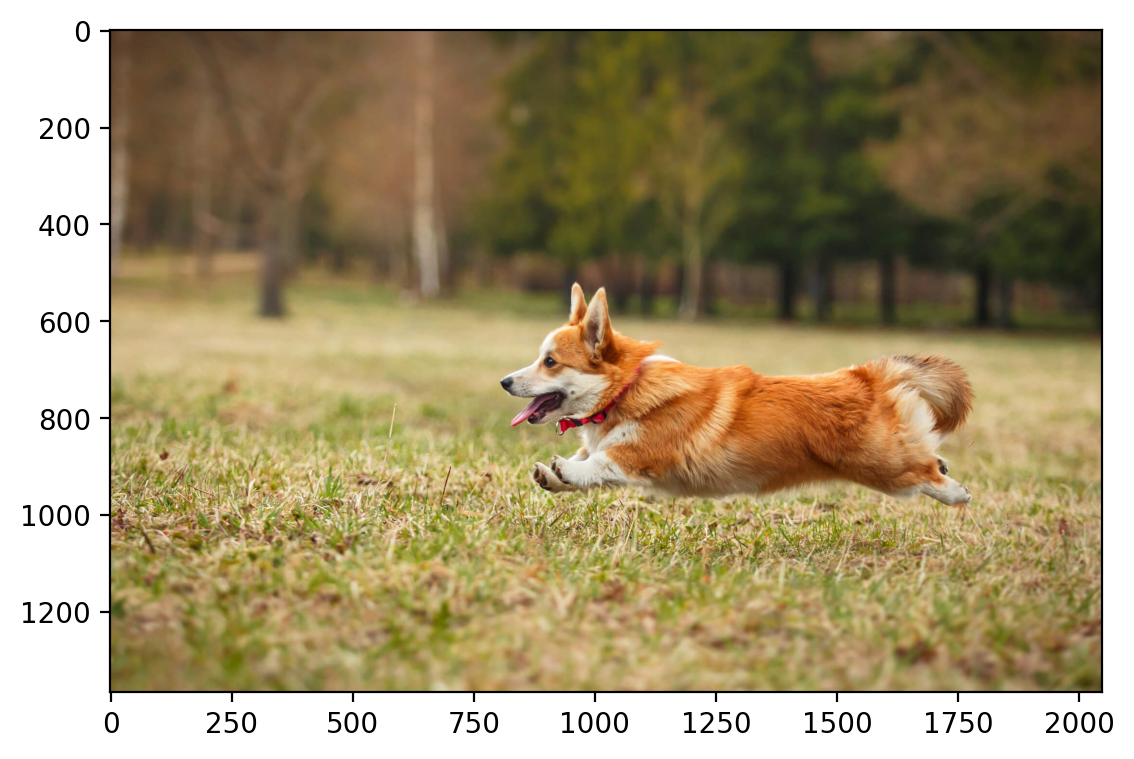

In [484]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


In [485]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [486]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [487]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [488]:
crop_img = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop_img.shape

torch.Size([3, 300, 300])

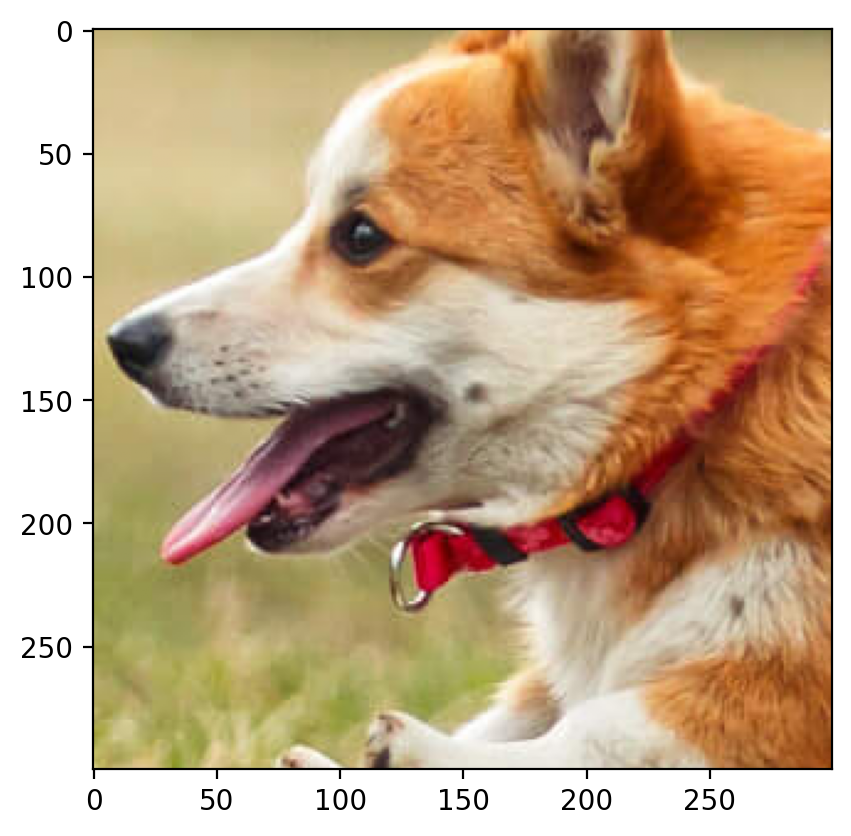

In [489]:
plt.imshow(rearrange(crop_img, 'c h w -> h w c').cpu().numpy())



In [490]:


from torchvision.transforms.functional import to_pil_image
from PIL import Image

# Convert the tensor to a PIL image
cropped_img_pil = to_pil_image(crop_img)

# Save the image in JPEG format
cropped_img_pil.save("cropped_image.jpg", format='JPEG')



In [491]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(crop_img.reshape(-1, 1))
scaler_img
img_scaled = scaler_img.transform(crop_img.reshape(-1, 1)).reshape(crop_img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.7686, 0.7686, 0.7686,  ..., 0.5451, 0.5451, 0.5412],
         [0.7725, 0.7725, 0.7725,  ..., 0.5686, 0.5686, 0.5647],
         [0.7765, 0.7765, 0.7765,  ..., 0.5882, 0.5843, 0.5843],
         ...,
         [0.7961, 0.7373, 0.7176,  ..., 0.5843, 0.5725, 0.5490],
         [0.8471, 0.7843, 0.7451,  ..., 0.6039, 0.5686, 0.5569],
         [0.8784, 0.8196, 0.7686,  ..., 0.6275, 0.5804, 0.5686]],

        [[0.6941, 0.6941, 0.6941,  ..., 0.5137, 0.5137, 0.5098],
         [0.6980, 0.6980, 0.6980,  ..., 0.5255, 0.5255, 0.5216],
         [0.7020, 0.7020, 0.7020,  ..., 0.5451, 0.5412, 0.5412],
         ...,
         [0.7686, 0.7098, 0.6863,  ..., 0.2824, 0.2706, 0.2431],
         [0.8157, 0.7569, 0.7137,  ..., 0.3059, 0.2667, 0.2431],
         [0.8431, 0.7882, 0.7333,  ..., 0.3294, 0.2706, 0.2588]],

        [[0.4745, 0.4745, 0.4745,  ..., 0.3294, 0.3294, 0.3255],
         [0.4784, 0.4784, 0.4784,  ..., 0.3451, 0.3451, 0.3412],
         [0.4824, 0.4824, 0.4824,  ..., 0.3647, 0.3608, 0.

In [492]:
crop_image1 = torchvision.transforms.functional.crop(img_scaled.cpu(), 0, 0, 50, 50)
crop_image1.shape

torch.Size([3, 50, 50])

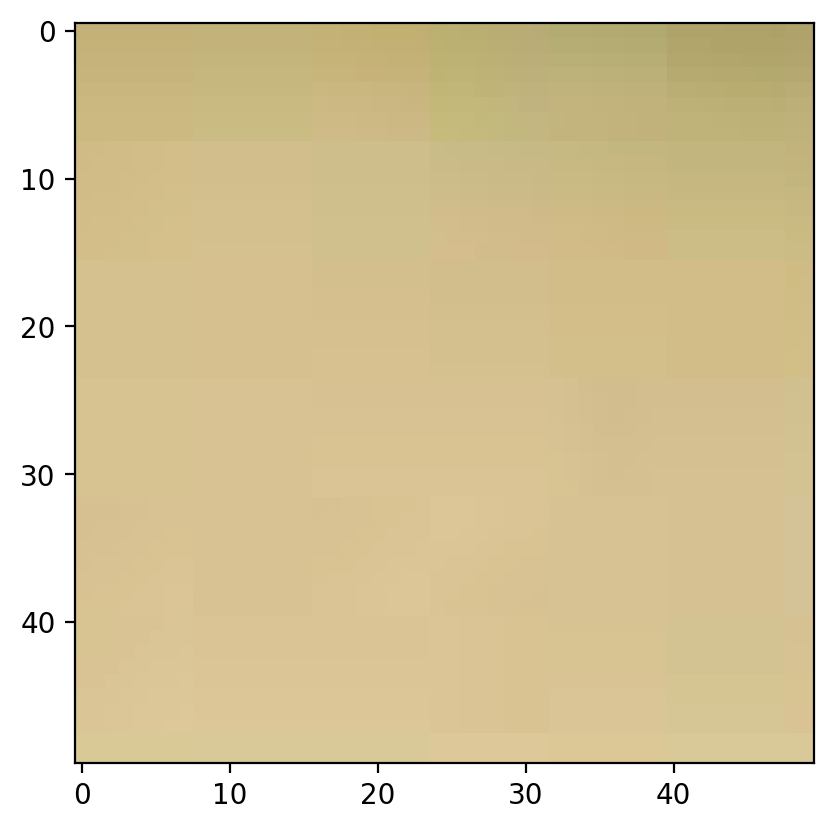

In [493]:
plt.imshow(rearrange(crop_image1, 'c h w -> h w c').cpu().numpy())

In [494]:

from torchvision.transforms.functional import to_pil_image
from PIL import Image

# Convert the tensor to a PIL image
cropped_img_pil = to_pil_image(crop_image1)

# Save the image in JPEG format
cropped_img_pil.save("cropped_image1.jpg", format='JPEG')



Original image shape: torch.Size([3, 50, 50])
Cropped image shape: torch.Size([3, 50, 50])
Rank: 5 | Average RMSE: 0.008592389523983002 | Average PSNR: 41.32391590811316 dB
Rank: 10 | Average RMSE: 0.005963344903041919 | Average PSNR: 44.647380037758374 dB
Rank: 25 | Average RMSE: 0.0062576401978731155 | Average PSNR: 44.07180743319153 dB
Rank: 50 | Average RMSE: 0.008513217171033224 | Average PSNR: 41.41385358318777 dB


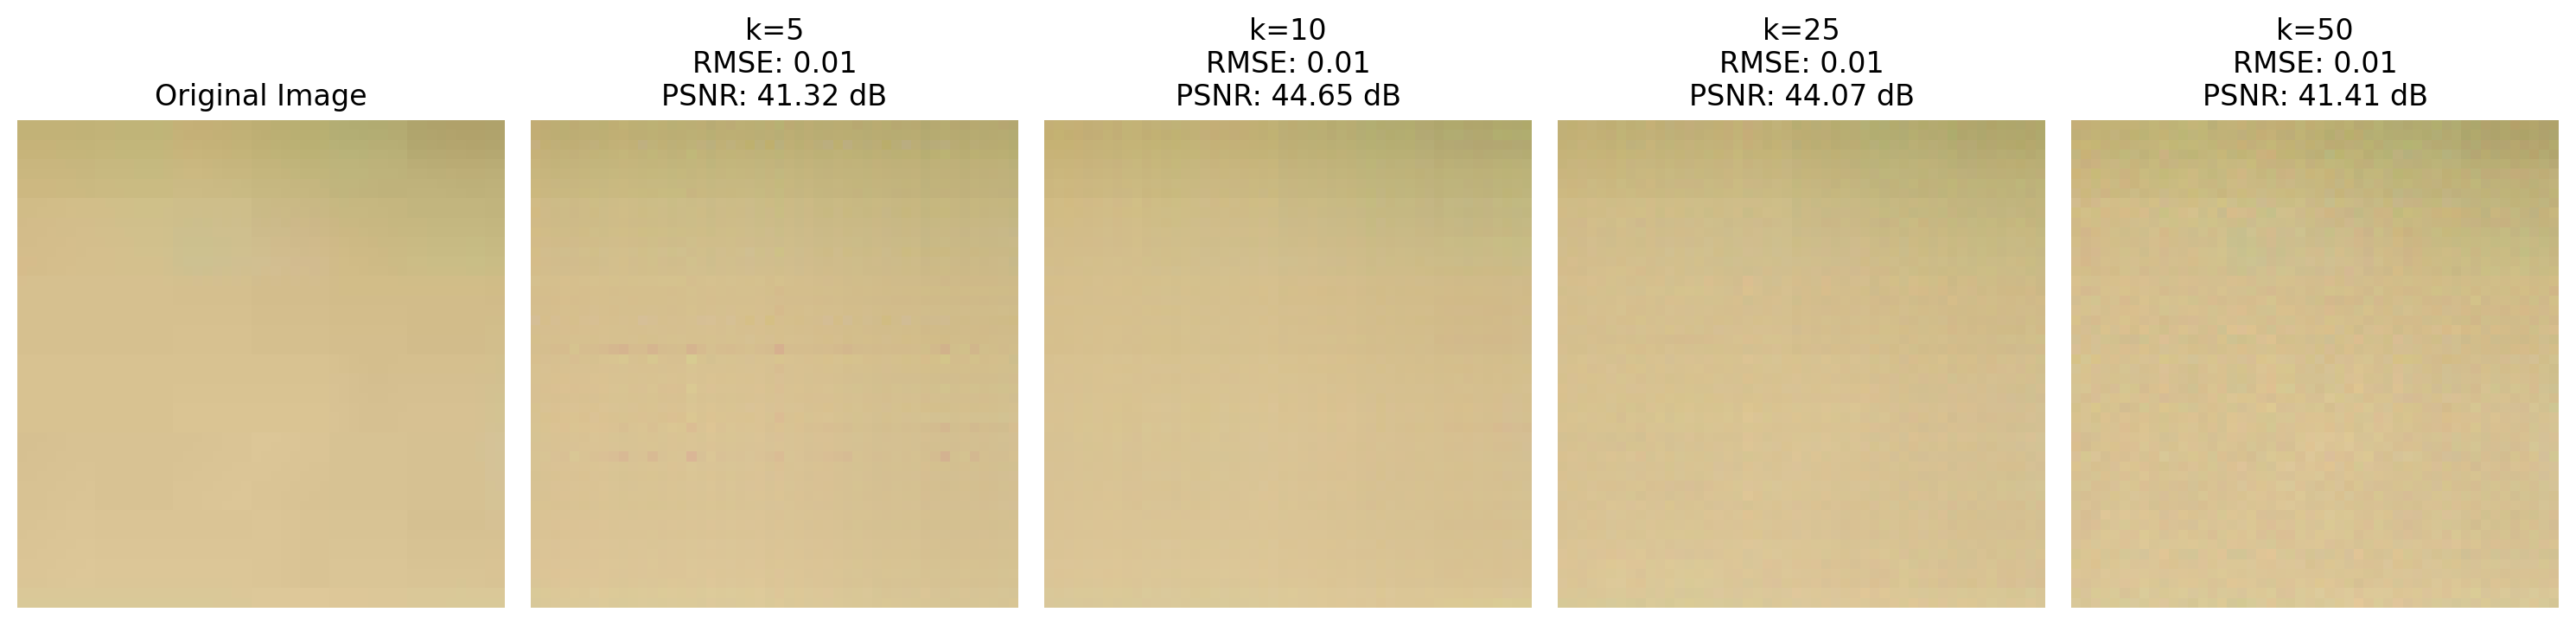

In [495]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import crop
import torch.optim as optim

# Define existing functions for RMSE and PSNR
def compute_rmse(original, reconstructed):
    original_np = original.cpu().numpy()
    reconstructed_np = reconstructed.cpu().numpy()
    mse_value = np.mean((original_np - reconstructed_np) ** 2)
    return np.sqrt(mse_value)

def compute_psnr(original, reconstructed, data_range=1.0):
    original_np = original.cpu().numpy()
    reconstructed_np = reconstructed.cpu().numpy()
    mse_value = np.mean((original_np - reconstructed_np) ** 2)
    if mse_value == 0:
        return float('inf')
    return 20 * np.log10(data_range / np.sqrt(mse_value))

# Load image (change the path to your own image path)
image_path = "cropped_image1.jpg"
img = torchvision.io.read_image(image_path).float() / 255.0  # Load image and normalize to [0, 1]
print(f"Original image shape: {img.shape}")  # Should show (C, H, W) for color images

# Crop the image
cropped_img = crop(img, top=0, left=0, height=50, width=50)  # Adjust the crop parameters as needed
print(f"Cropped image shape: {cropped_img.shape}")  # Should show (C, 50, 50)

# Convert the cropped image to separate color channels (C, H, W)
channels = cropped_img

# Updated factorize function with convergence
def factorize(A, k, device=torch.device("cpu"), lr=0.01, max_iters=10000, tol=1e-4):
    A = A.to(device)
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=lr)

    prev_loss = float('inf')

    for i in range(max_iters):
        loss = torch.norm(torch.mm(W, H) - A)
        if abs(prev_loss - loss.item()) < tol:
            break
        prev_loss = loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return W, H, loss

# Define ranks for comparison
k_values = [5, 10, 25, 50]

# Initialize figure for plotting
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # One row, five columns (for original + 4 ks)

# Plot the original image
axes[0].imshow(cropped_img.permute(1, 2, 0).numpy())  # Convert (C, H, W) to (H, W, C)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Loop over different k values to reconstruct the image and calculate metrics
for idx, k in enumerate(k_values):
    reconstructed_channels = []

    # Process each color channel separately
    for i in range(channels.shape[0]):
        channel = channels[i, :, :]  # Each color channel is (H, W)
        W, H, _ = factorize(channel, k)  # Using your factorization function
        reconstructed_channel = torch.mm(W, H).cpu().detach()
        reconstructed_channels.append(reconstructed_channel.unsqueeze(0))  # Add channel back with batch dim

    # Combine the reconstructed channels back into a full image (C, H, W)
    reconstructed_img = torch.cat(reconstructed_channels, dim=0).permute(1, 2, 0).cpu().numpy()

    # Compute RMSE and PSNR for each channel
    rmse_total = 0
    psnr_total = 0

    for i in range(channels.shape[0]):
        original_channel = torch.tensor(cropped_img[i, :, :], dtype=torch.float32)
        reconstructed_channel = torch.tensor(reconstructed_img[:, :, i], dtype=torch.float32)
        rmse_value = compute_rmse(original_channel, reconstructed_channel)
        psnr_value = compute_psnr(original_channel, reconstructed_channel, data_range=1.0)
        rmse_total += rmse_value
        psnr_total += psnr_value

    # Calculate average RMSE and PSNR across channels
    average_rmse = rmse_total / channels.shape[0]
    average_psnr = psnr_total / channels.shape[0]

    # Print the results
    print(f'Rank: {k} | Average RMSE: {average_rmse} | Average PSNR: {average_psnr} dB')

    # Plot the reconstructed image for this rank
    axes[idx + 1].imshow(reconstructed_img)
    axes[idx + 1].set_title(f"k={k}\nRMSE: {average_rmse:.2f}\nPSNR: {average_psnr:.2f} dB")
    axes[idx + 1].axis('off')

# Display the plot
plt.tight_layout()
plt.show()


In [496]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(crop_img.reshape(-1, 1))
scaler_img
img_scaled = scaler_img.transform(crop_img.reshape(-1, 1)).reshape(crop_img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.7686, 0.7686, 0.7686,  ..., 0.5451, 0.5451, 0.5412],
         [0.7725, 0.7725, 0.7725,  ..., 0.5686, 0.5686, 0.5647],
         [0.7765, 0.7765, 0.7765,  ..., 0.5882, 0.5843, 0.5843],
         ...,
         [0.7961, 0.7373, 0.7176,  ..., 0.5843, 0.5725, 0.5490],
         [0.8471, 0.7843, 0.7451,  ..., 0.6039, 0.5686, 0.5569],
         [0.8784, 0.8196, 0.7686,  ..., 0.6275, 0.5804, 0.5686]],

        [[0.6941, 0.6941, 0.6941,  ..., 0.5137, 0.5137, 0.5098],
         [0.6980, 0.6980, 0.6980,  ..., 0.5255, 0.5255, 0.5216],
         [0.7020, 0.7020, 0.7020,  ..., 0.5451, 0.5412, 0.5412],
         ...,
         [0.7686, 0.7098, 0.6863,  ..., 0.2824, 0.2706, 0.2431],
         [0.8157, 0.7569, 0.7137,  ..., 0.3059, 0.2667, 0.2431],
         [0.8431, 0.7882, 0.7333,  ..., 0.3294, 0.2706, 0.2588]],

        [[0.4745, 0.4745, 0.4745,  ..., 0.3294, 0.3294, 0.3255],
         [0.4784, 0.4784, 0.4784,  ..., 0.3451, 0.3451, 0.3412],
         [0.4824, 0.4824, 0.4824,  ..., 0.3647, 0.3608, 0.

In [497]:
crop_image2 = torchvision.transforms.functional.crop(img_scaled.cpu(), 60, 40, 50, 50)
crop_image2.shape

torch.Size([3, 50, 50])

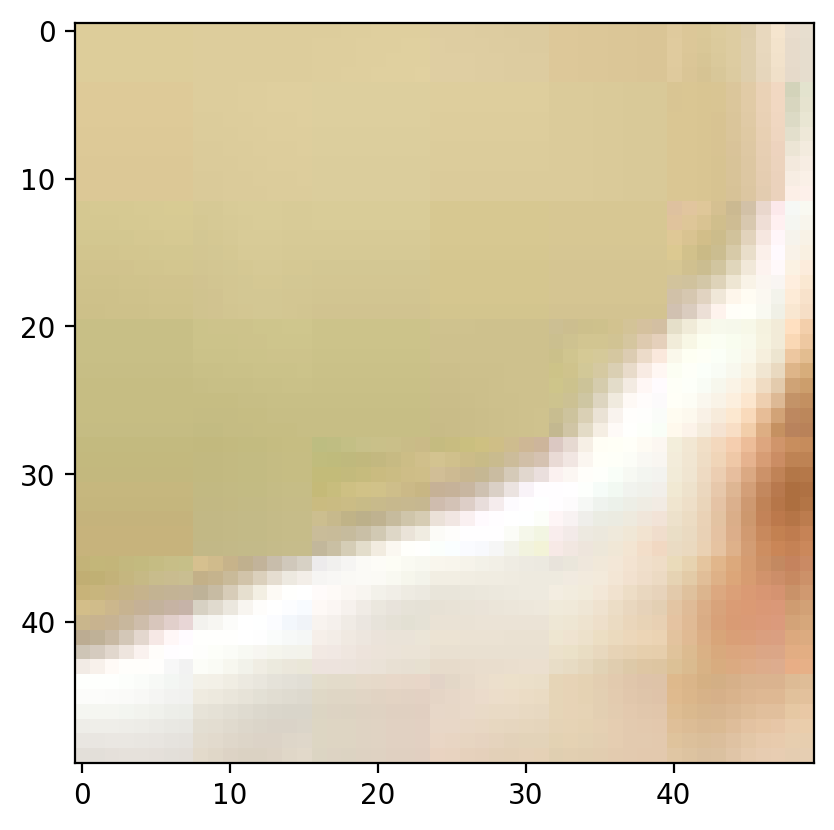

In [498]:
plt.imshow(rearrange(crop_image2, 'c h w -> h w c').cpu().numpy())

In [499]:

from torchvision.transforms.functional import to_pil_image
from PIL import Image

# Convert the tensor to a PIL image
cropped_img_pil = to_pil_image(crop_image2)

# Save the image in JPEG format
cropped_img_pil.save("cropped_image2.jpg", format='JPEG')



Original image shape: torch.Size([3, 50, 50])
Cropped image shape: torch.Size([3, 50, 50])


Rank: 5 | Average RMSE: 0.031518026565512024 | Average PSNR: 30.12252372118496 dB


Rank: 10 | Average RMSE: 0.030816281214356422 | Average PSNR: 30.270260519799027 dB


Rank: 25 | Average RMSE: 0.01922273263335228 | Average PSNR: 34.4069464699654 dB


Rank: 50 | Average RMSE: 0.017190225732823212 | Average PSNR: 35.64382308615871 dB


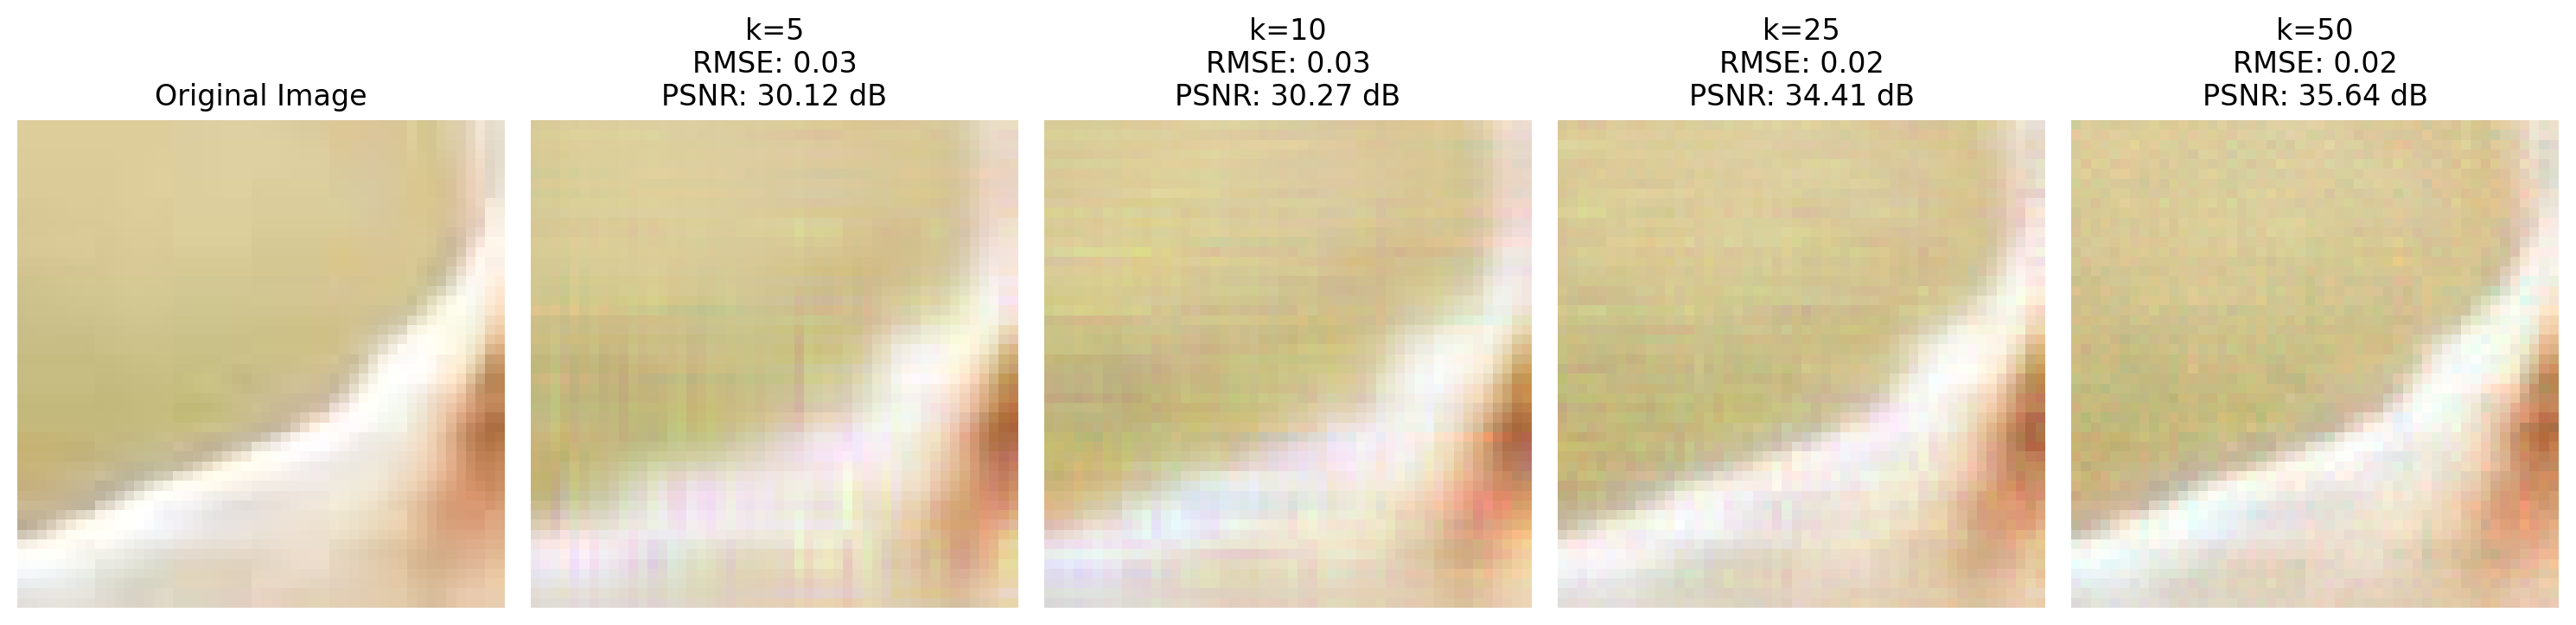

In [500]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import crop
import torch.optim as optim

# Define existing functions for RMSE and PSNR
def compute_rmse(original, reconstructed):
    original_np = original.cpu().numpy()
    reconstructed_np = reconstructed.cpu().numpy()
    mse_value = np.mean((original_np - reconstructed_np) ** 2)
    return np.sqrt(mse_value)

def compute_psnr(original, reconstructed, data_range=1.0):
    original_np = original.cpu().numpy()
    reconstructed_np = reconstructed.cpu().numpy()
    mse_value = np.mean((original_np - reconstructed_np) ** 2)
    if mse_value == 0:
        return float('inf')
    return 20 * np.log10(data_range / np.sqrt(mse_value))

# Load image (change the path to your own image path)
image_path = "cropped_image2.jpg"
img = torchvision.io.read_image(image_path).float() / 255.0  # Load image and normalize to [0, 1]
print(f"Original image shape: {img.shape}")  # Should show (C, H, W) for color images

# Crop the image
cropped_img = crop(img, top=0, left=0, height=50, width=50)  # Adjust the crop parameters as needed
print(f"Cropped image shape: {cropped_img.shape}")  # Should show (C, 50, 50)

# Convert the cropped image to separate color channels (C, H, W)
channels = cropped_img

# Updated factorize function with convergence
def factorize(A, k, device=torch.device("cpu"), lr=0.01, max_iters=10000, tol=1e-4):
    A = A.to(device)
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=lr)

    prev_loss = float('inf')

    for i in range(max_iters):
        loss = torch.norm(torch.mm(W, H) - A)
        if abs(prev_loss - loss.item()) < tol:
            break
        prev_loss = loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return W, H, loss

# Define ranks for comparison
k_values = [5, 10, 25, 50]

# Initialize figure for plotting
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # One row, five columns (for original + 4 ks)

# Plot the original image
axes[0].imshow(cropped_img.permute(1, 2, 0).numpy())  # Convert (C, H, W) to (H, W, C)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Loop over different k values to reconstruct the image and calculate metrics
for idx, k in enumerate(k_values):
    reconstructed_channels = []

    # Process each color channel separately
    for i in range(channels.shape[0]):
        channel = channels[i, :, :]  # Each color channel is (H, W)
        W, H, _ = factorize(channel, k)  # Using your factorization function
        reconstructed_channel = torch.mm(W, H).cpu().detach()
        reconstructed_channels.append(reconstructed_channel.unsqueeze(0))  # Add channel back with batch dim

    # Combine the reconstructed channels back into a full image (C, H, W)
    reconstructed_img = torch.cat(reconstructed_channels, dim=0).permute(1, 2, 0).cpu().numpy()

    # Compute RMSE and PSNR for each channel
    rmse_total = 0
    psnr_total = 0

    for i in range(channels.shape[0]):
        original_channel = torch.tensor(cropped_img[i, :, :], dtype=torch.float32)
        reconstructed_channel = torch.tensor(reconstructed_img[:, :, i], dtype=torch.float32)
        rmse_value = compute_rmse(original_channel, reconstructed_channel)
        psnr_value = compute_psnr(original_channel, reconstructed_channel, data_range=1.0)
        rmse_total += rmse_value
        psnr_total += psnr_value

    # Calculate average RMSE and PSNR across channels
    average_rmse = rmse_total / channels.shape[0]
    average_psnr = psnr_total / channels.shape[0]

    # Print the results
    print(f'Rank: {k} | Average RMSE: {average_rmse} | Average PSNR: {average_psnr} dB')

    # Plot the reconstructed image for this rank
    axes[idx + 1].imshow(reconstructed_img)
    axes[idx + 1].set_title(f"k={k}\nRMSE: {average_rmse:.2f}\nPSNR: {average_psnr:.2f} dB")
    axes[idx + 1].axis('off')

# Display the plot
plt.tight_layout()
plt.show()


In [501]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(crop_img.reshape(-1, 1))
scaler_img
img_scaled = scaler_img.transform(crop_img.reshape(-1, 1)).reshape(crop_img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled


tensor([[[0.7686, 0.7686, 0.7686,  ..., 0.5451, 0.5451, 0.5412],
         [0.7725, 0.7725, 0.7725,  ..., 0.5686, 0.5686, 0.5647],
         [0.7765, 0.7765, 0.7765,  ..., 0.5882, 0.5843, 0.5843],
         ...,
         [0.7961, 0.7373, 0.7176,  ..., 0.5843, 0.5725, 0.5490],
         [0.8471, 0.7843, 0.7451,  ..., 0.6039, 0.5686, 0.5569],
         [0.8784, 0.8196, 0.7686,  ..., 0.6275, 0.5804, 0.5686]],

        [[0.6941, 0.6941, 0.6941,  ..., 0.5137, 0.5137, 0.5098],
         [0.6980, 0.6980, 0.6980,  ..., 0.5255, 0.5255, 0.5216],
         [0.7020, 0.7020, 0.7020,  ..., 0.5451, 0.5412, 0.5412],
         ...,
         [0.7686, 0.7098, 0.6863,  ..., 0.2824, 0.2706, 0.2431],
         [0.8157, 0.7569, 0.7137,  ..., 0.3059, 0.2667, 0.2431],
         [0.8431, 0.7882, 0.7333,  ..., 0.3294, 0.2706, 0.2588]],

        [[0.4745, 0.4745, 0.4745,  ..., 0.3294, 0.3294, 0.3255],
         [0.4784, 0.4784, 0.4784,  ..., 0.3451, 0.3451, 0.3412],
         [0.4824, 0.4824, 0.4824,  ..., 0.3647, 0.3608, 0.

In [502]:
crop_image3 = torchvision.transforms.functional.crop(img_scaled.cpu(), 175, 90, 50, 50)
crop_image3.shape

torch.Size([3, 50, 50])

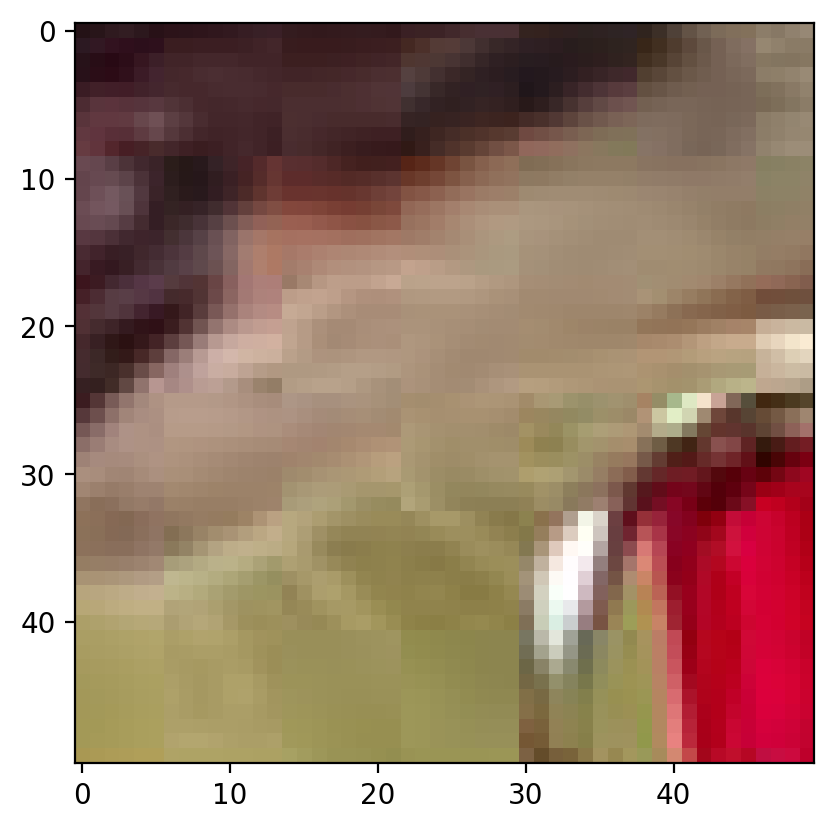

In [503]:
plt.imshow(rearrange(crop_image3, 'c h w -> h w c').cpu().numpy())

In [504]:

from torchvision.transforms.functional import to_pil_image
from PIL import Image

# Convert the tensor to a PIL image
cropped_img_pil = to_pil_image(crop_image3)

# Save the image in JPEG format
cropped_img_pil.save("cropped_image3.jpg", format='JPEG')



Original image shape: torch.Size([3, 50, 50])
Cropped image shape: torch.Size([3, 50, 50])


Rank: 5 | Average RMSE: 0.05384579921762148 | Average PSNR: 25.389024554425124 dB


Rank: 10 | Average RMSE: 0.03951031466325124 | Average PSNR: 28.071213567512345 dB


Rank: 25 | Average RMSE: 0.02806061754624049 | Average PSNR: 31.0407712793737 dB


Rank: 50 | Average RMSE: 0.019669306774934132 | Average PSNR: 34.330130276506516 dB


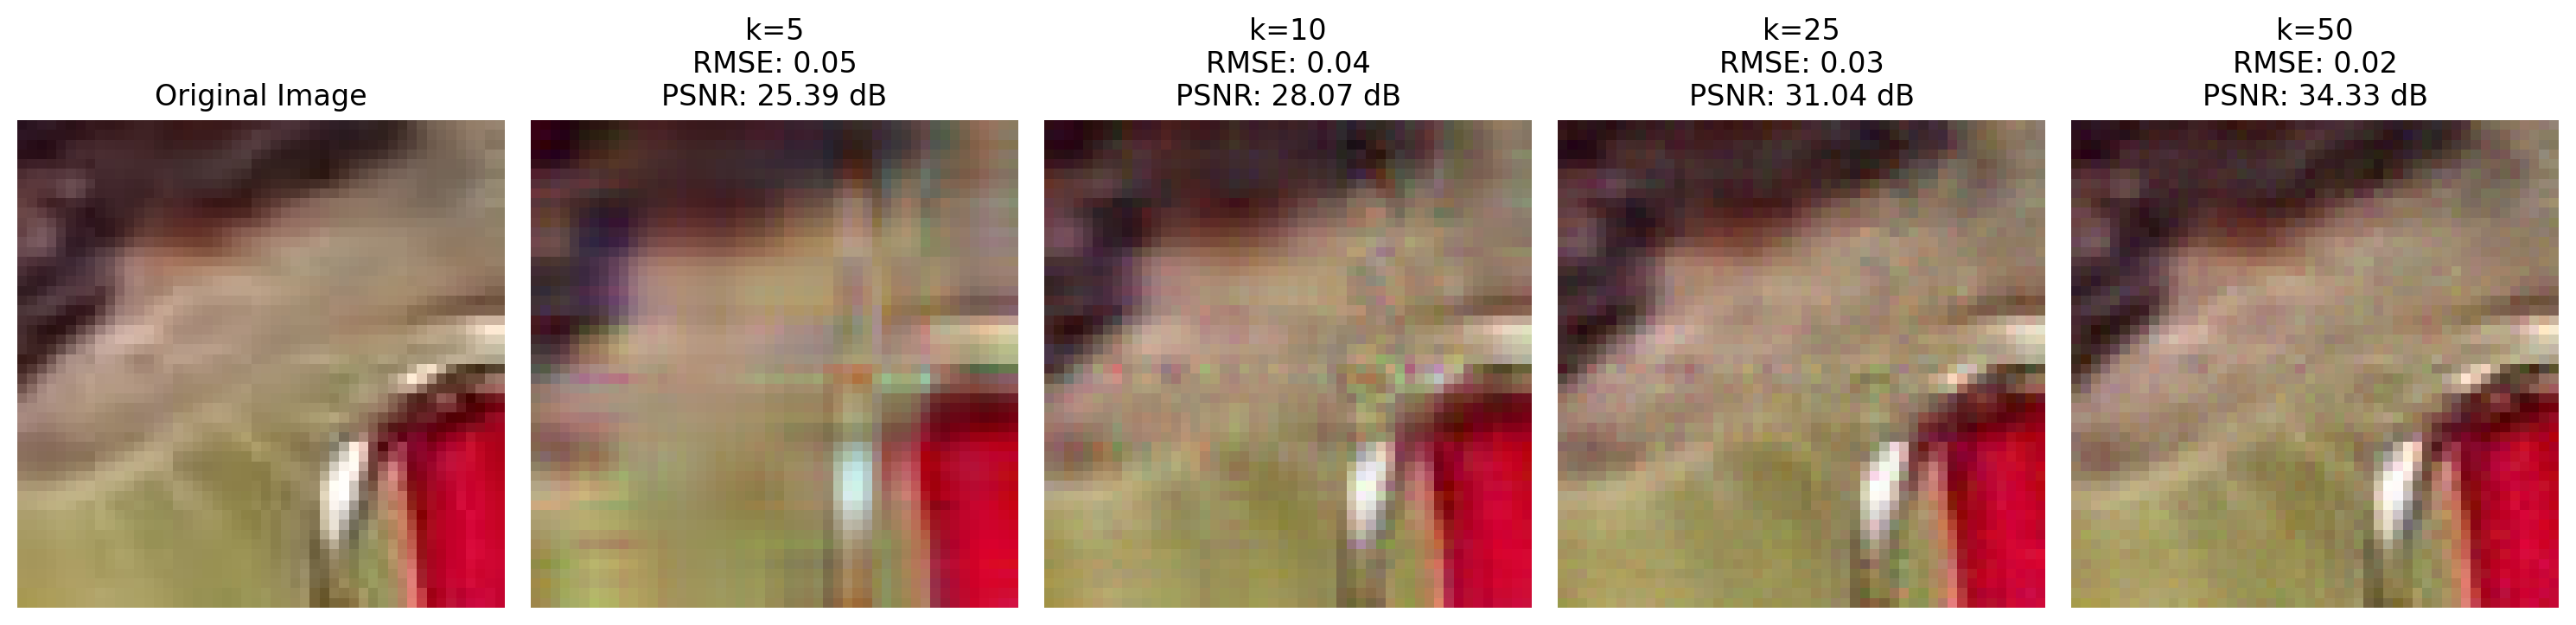

In [505]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import crop
import torch.optim as optim

# Define existing functions for RMSE and PSNR
def compute_rmse(original, reconstructed):
    original_np = original.cpu().numpy()
    reconstructed_np = reconstructed.cpu().numpy()
    mse_value = np.mean((original_np - reconstructed_np) ** 2)
    return np.sqrt(mse_value)

def compute_psnr(original, reconstructed, data_range=1.0):
    original_np = original.cpu().numpy()
    reconstructed_np = reconstructed.cpu().numpy()
    mse_value = np.mean((original_np - reconstructed_np) ** 2)
    if mse_value == 0:
        return float('inf')
    return 20 * np.log10(data_range / np.sqrt(mse_value))

# Load image (change the path to your own image path)
image_path = "cropped_image3.jpg"
img = torchvision.io.read_image(image_path).float() / 255.0  # Load image and normalize to [0, 1]
print(f"Original image shape: {img.shape}")  # Should show (C, H, W) for color images

# Crop the image
cropped_img = crop(img, top=0, left=0, height=50, width=50)  # Adjust the crop parameters as needed
print(f"Cropped image shape: {cropped_img.shape}")  # Should show (C, 50, 50)

# Convert the cropped image to separate color channels (C, H, W)
channels = cropped_img

# Updated factorize function with convergence
def factorize(A, k, device=torch.device("cpu"), lr=0.01, max_iters=10000, tol=1e-4):
    A = A.to(device)
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=lr)

    prev_loss = float('inf')

    for i in range(max_iters):
        loss = torch.norm(torch.mm(W, H) - A)
        if abs(prev_loss - loss.item()) < tol:
            break
        prev_loss = loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return W, H, loss

# Define ranks for comparison
k_values = [5, 10, 25, 50]

# Initialize figure for plotting
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # One row, five columns (for original + 4 ks)

# Plot the original image
axes[0].imshow(cropped_img.permute(1, 2, 0).numpy())  # Convert (C, H, W) to (H, W, C)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Loop over different k values to reconstruct the image and calculate metrics
for idx, k in enumerate(k_values):
    reconstructed_channels = []

    # Process each color channel separately
    for i in range(channels.shape[0]):
        channel = channels[i, :, :]  # Each color channel is (H, W)
        W, H, _ = factorize(channel, k)  # Using your factorization function
        reconstructed_channel = torch.mm(W, H).cpu().detach()
        reconstructed_channels.append(reconstructed_channel.unsqueeze(0))  # Add channel back with batch dim

    # Combine the reconstructed channels back into a full image (C, H, W)
    reconstructed_img = torch.cat(reconstructed_channels, dim=0).permute(1, 2, 0).cpu().numpy()

    # Compute RMSE and PSNR for each channel
    rmse_total = 0
    psnr_total = 0

    for i in range(channels.shape[0]):
        original_channel = torch.tensor(cropped_img[i, :, :], dtype=torch.float32)
        reconstructed_channel = torch.tensor(reconstructed_img[:, :, i], dtype=torch.float32)
        rmse_value = compute_rmse(original_channel, reconstructed_channel)
        psnr_value = compute_psnr(original_channel, reconstructed_channel, data_range=1.0)
        rmse_total += rmse_value
        psnr_total += psnr_value

    # Calculate average RMSE and PSNR across channels
    average_rmse = rmse_total / channels.shape[0]
    average_psnr = psnr_total / channels.shape[0]

    # Print the results
    print(f'Rank: {k} | Average RMSE: {average_rmse} | Average PSNR: {average_psnr} dB')

    # Plot the reconstructed image for this rank
    axes[idx + 1].imshow(reconstructed_img)
    axes[idx + 1].set_title(f"k={k}\nRMSE: {average_rmse:.2f}\nPSNR: {average_psnr:.2f} dB")
    axes[idx + 1].axis('off')

# Display the plot
plt.tight_layout()
plt.show()


In [506]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(crop_img.reshape(-1, 1))
scaler_img
img_scaled = scaler_img.transform(crop_img.reshape(-1, 1)).reshape(crop_img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.7686, 0.7686, 0.7686,  ..., 0.5451, 0.5451, 0.5412],
         [0.7725, 0.7725, 0.7725,  ..., 0.5686, 0.5686, 0.5647],
         [0.7765, 0.7765, 0.7765,  ..., 0.5882, 0.5843, 0.5843],
         ...,
         [0.7961, 0.7373, 0.7176,  ..., 0.5843, 0.5725, 0.5490],
         [0.8471, 0.7843, 0.7451,  ..., 0.6039, 0.5686, 0.5569],
         [0.8784, 0.8196, 0.7686,  ..., 0.6275, 0.5804, 0.5686]],

        [[0.6941, 0.6941, 0.6941,  ..., 0.5137, 0.5137, 0.5098],
         [0.6980, 0.6980, 0.6980,  ..., 0.5255, 0.5255, 0.5216],
         [0.7020, 0.7020, 0.7020,  ..., 0.5451, 0.5412, 0.5412],
         ...,
         [0.7686, 0.7098, 0.6863,  ..., 0.2824, 0.2706, 0.2431],
         [0.8157, 0.7569, 0.7137,  ..., 0.3059, 0.2667, 0.2431],
         [0.8431, 0.7882, 0.7333,  ..., 0.3294, 0.2706, 0.2588]],

        [[0.4745, 0.4745, 0.4745,  ..., 0.3294, 0.3294, 0.3255],
         [0.4784, 0.4784, 0.4784,  ..., 0.3451, 0.3451, 0.3412],
         [0.4824, 0.4824, 0.4824,  ..., 0.3647, 0.3608, 0.

In [507]:
crop_image4 = torchvision.transforms.functional.crop(img_scaled.cpu(), 0, 0, 300, 300)
crop_image4.shape

torch.Size([3, 300, 300])

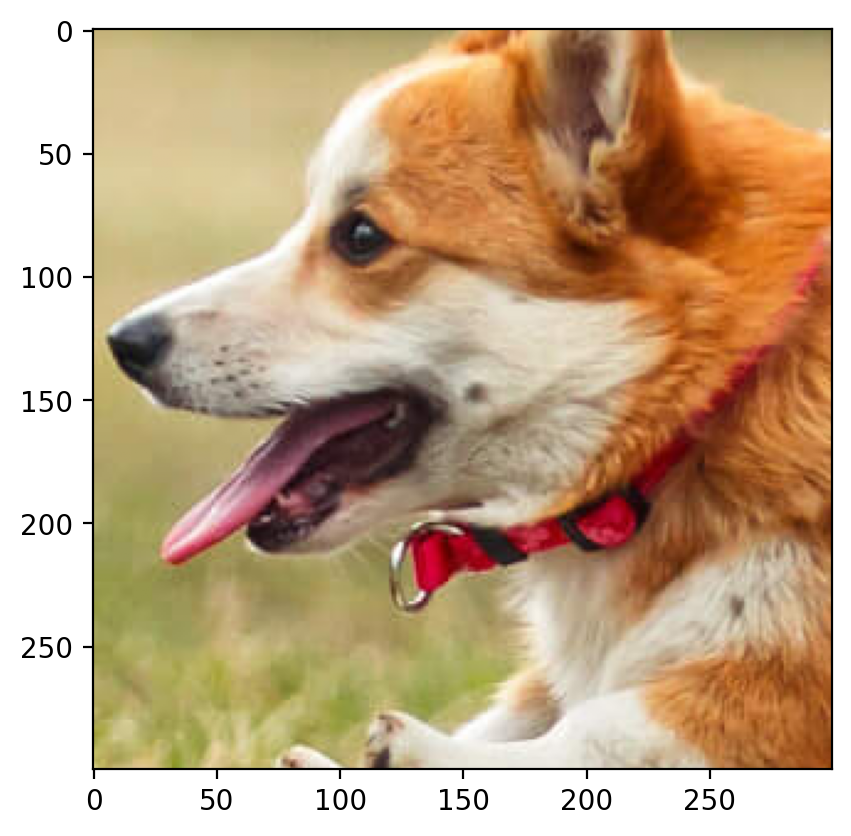

In [508]:
plt.imshow(rearrange(crop_image4, 'c h w -> h w c').cpu().numpy())

In [509]:

from torchvision.transforms.functional import to_pil_image
from PIL import Image

# Convert the tensor to a PIL image
cropped_img_pil = to_pil_image(crop_image4)

# Save the image in JPEG format
cropped_img_pil.save("cropped_image4.jpg", format='JPEG')



Original image shape: torch.Size([3, 300, 300])
Cropped image shape: torch.Size([3, 300, 300])


Rank: 50 | Average RMSE: 0.048193808645009995 | Average PSNR: 26.34160494715856 dB


Rank: 100 | Average RMSE: 0.0414334274828434 | Average PSNR: 27.676921518117535 dB


Rank: 125 | Average RMSE: 0.03353552334010601 | Average PSNR: 29.557400889943825 dB


Rank: 250 | Average RMSE: 0.031942183151841164 | Average PSNR: 29.972707248262783 dB


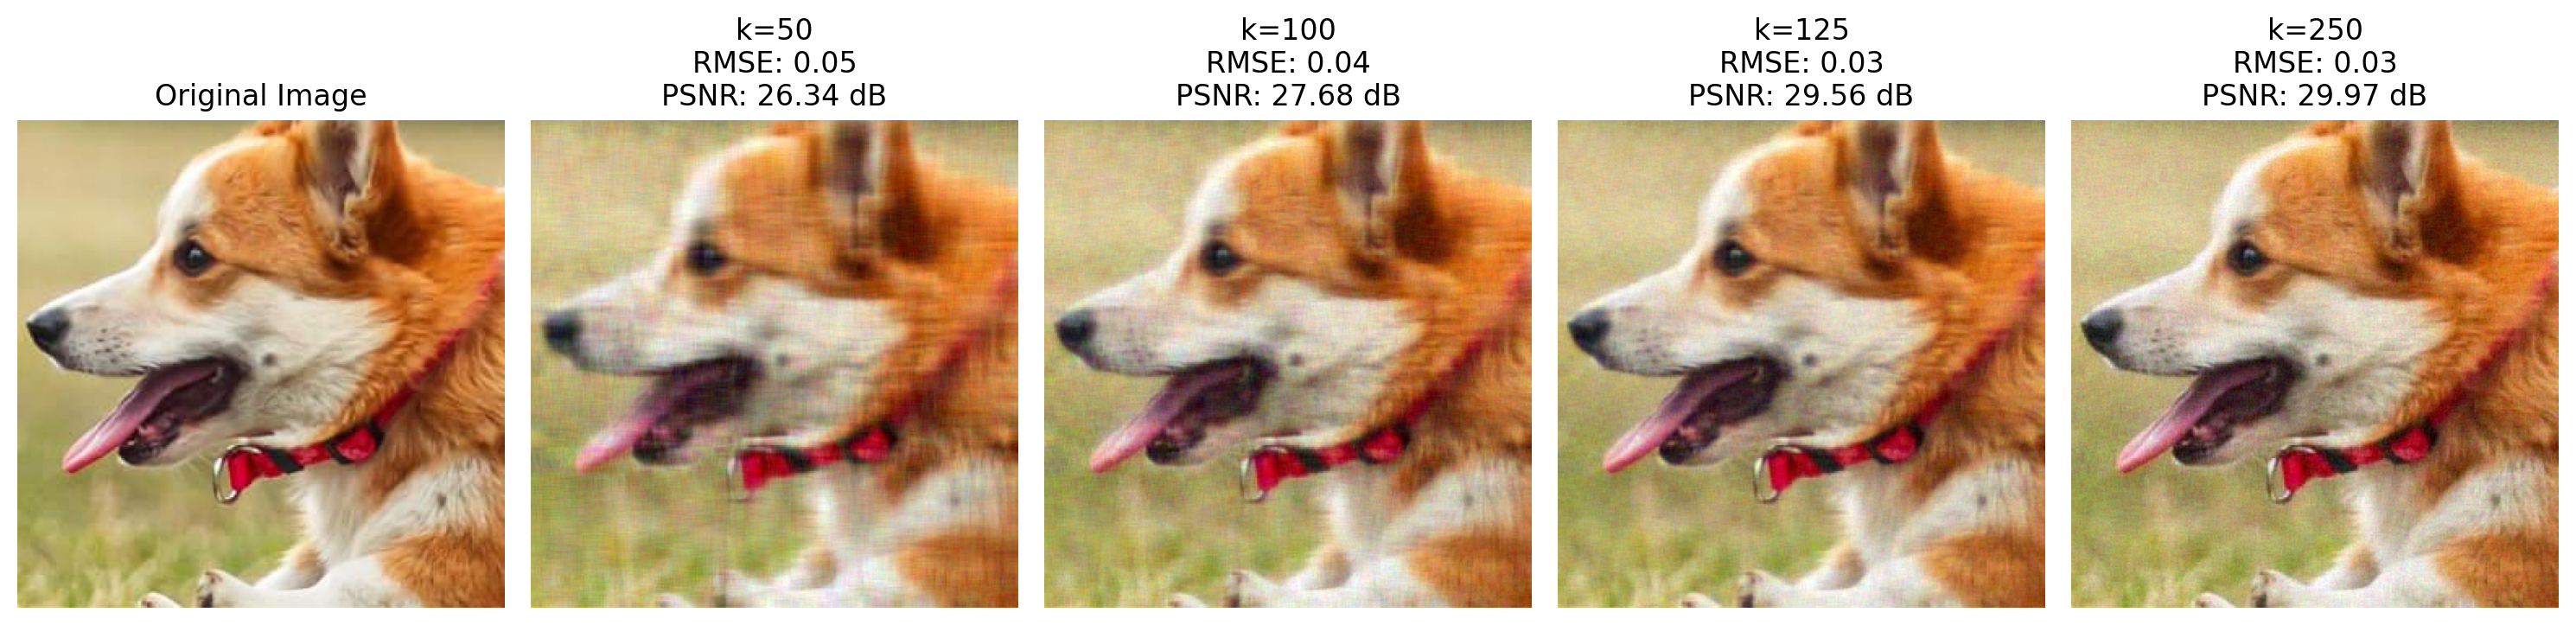

In [512]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import crop
import torch.optim as optim

# Define existing functions for RMSE and PSNR
def compute_rmse(original, reconstructed):
    original_np = original.cpu().numpy()
    reconstructed_np = reconstructed.cpu().numpy()
    mse_value = np.mean((original_np - reconstructed_np) ** 2)
    return np.sqrt(mse_value)

def compute_psnr(original, reconstructed, data_range=1.0):
    original_np = original.cpu().numpy()
    reconstructed_np = reconstructed.cpu().numpy()
    mse_value = np.mean((original_np - reconstructed_np) ** 2)
    if mse_value == 0:
        return float('inf')
    return 20 * np.log10(data_range / np.sqrt(mse_value))

# Load image (change the path to your own image path)
image_path = "cropped_image4.jpg"
img = torchvision.io.read_image(image_path).float() / 255.0  # Load image and normalize to [0, 1]
print(f"Original image shape: {img.shape}")  # Should show (C, H, W) for color images

# Crop the image
cropped_img = crop(img, top=0, left=0, height=300, width=300)  # Adjust the crop parameters as needed
print(f"Cropped image shape: {cropped_img.shape}")  # Should show (C, 50, 50)

# Convert the cropped image to separate color channels (C, H, W)
channels = cropped_img

# Updated factorize function with convergence
def factorize(A, k, device=torch.device("cpu"), lr=0.01, max_iters=10000, tol=1e-4):
    A = A.to(device)
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=lr)

    prev_loss = float('inf')

    for i in range(max_iters):
        loss = torch.norm(torch.mm(W, H) - A)
        if abs(prev_loss - loss.item()) < tol:
            break
        prev_loss = loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return W, H, loss

# Define ranks for comparison
k_values = [50, 100, 125, 250]

# Initialize figure for plotting
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # One row, five columns (for original + 4 ks)

# Plot the original image
axes[0].imshow(cropped_img.permute(1, 2, 0).numpy())  # Convert (C, H, W) to (H, W, C)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Loop over different k values to reconstruct the image and calculate metrics
for idx, k in enumerate(k_values):
    reconstructed_channels = []

    # Process each color channel separately
    for i in range(channels.shape[0]):
        channel = channels[i, :, :]  # Each color channel is (H, W)
        W, H, _ = factorize(channel, k)  # Using your factorization function
        reconstructed_channel = torch.mm(W, H).cpu().detach()
        reconstructed_channels.append(reconstructed_channel.unsqueeze(0))  # Add channel back with batch dim

    # Combine the reconstructed channels back into a full image (C, H, W)
    reconstructed_img = torch.cat(reconstructed_channels, dim=0).permute(1, 2, 0).cpu().numpy()

    # Compute RMSE and PSNR for each channel
    rmse_total = 0
    psnr_total = 0

    for i in range(channels.shape[0]):
        original_channel = torch.tensor(cropped_img[i, :, :], dtype=torch.float32)
        reconstructed_channel = torch.tensor(reconstructed_img[:, :, i], dtype=torch.float32)
        rmse_value = compute_rmse(original_channel, reconstructed_channel)
        psnr_value = compute_psnr(original_channel, reconstructed_channel, data_range=1.0)
        rmse_total += rmse_value
        psnr_total += psnr_value

    # Calculate average RMSE and PSNR across channels
    average_rmse = rmse_total / channels.shape[0]
    average_psnr = psnr_total / channels.shape[0]

    # Print the results
    print(f'Rank: {k} | Average RMSE: {average_rmse} | Average PSNR: {average_psnr} dB')

    # Plot the reconstructed image for this rank
    axes[idx + 1].imshow(reconstructed_img)
    axes[idx + 1].set_title(f"k={k}\nRMSE: {average_rmse:.2f}\nPSNR: {average_psnr:.2f} dB")
    axes[idx + 1].axis('off')

# Display the plot
plt.tight_layout()
plt.show()
